# SPI Calculation and Visualization for East Africa

## Overview

This Python script performs the calculation and visualization of the Standardized Precipitation Index (SPI) for East Africa using precipitation data from the CRU TS4.05 dataset. The SPI values are calculated for each month of the year and visualized on a 3x4 grid of subplots.

## Dependencies

- `distributed`
- `pandas`
- `xarray`
- `numpy`
- `scipy`
- `matplotlib`
- `geopandas`

Install the required dependencies using:

```bash
pip install distributed pandas xarray numpy scipy matplotlib geopandas


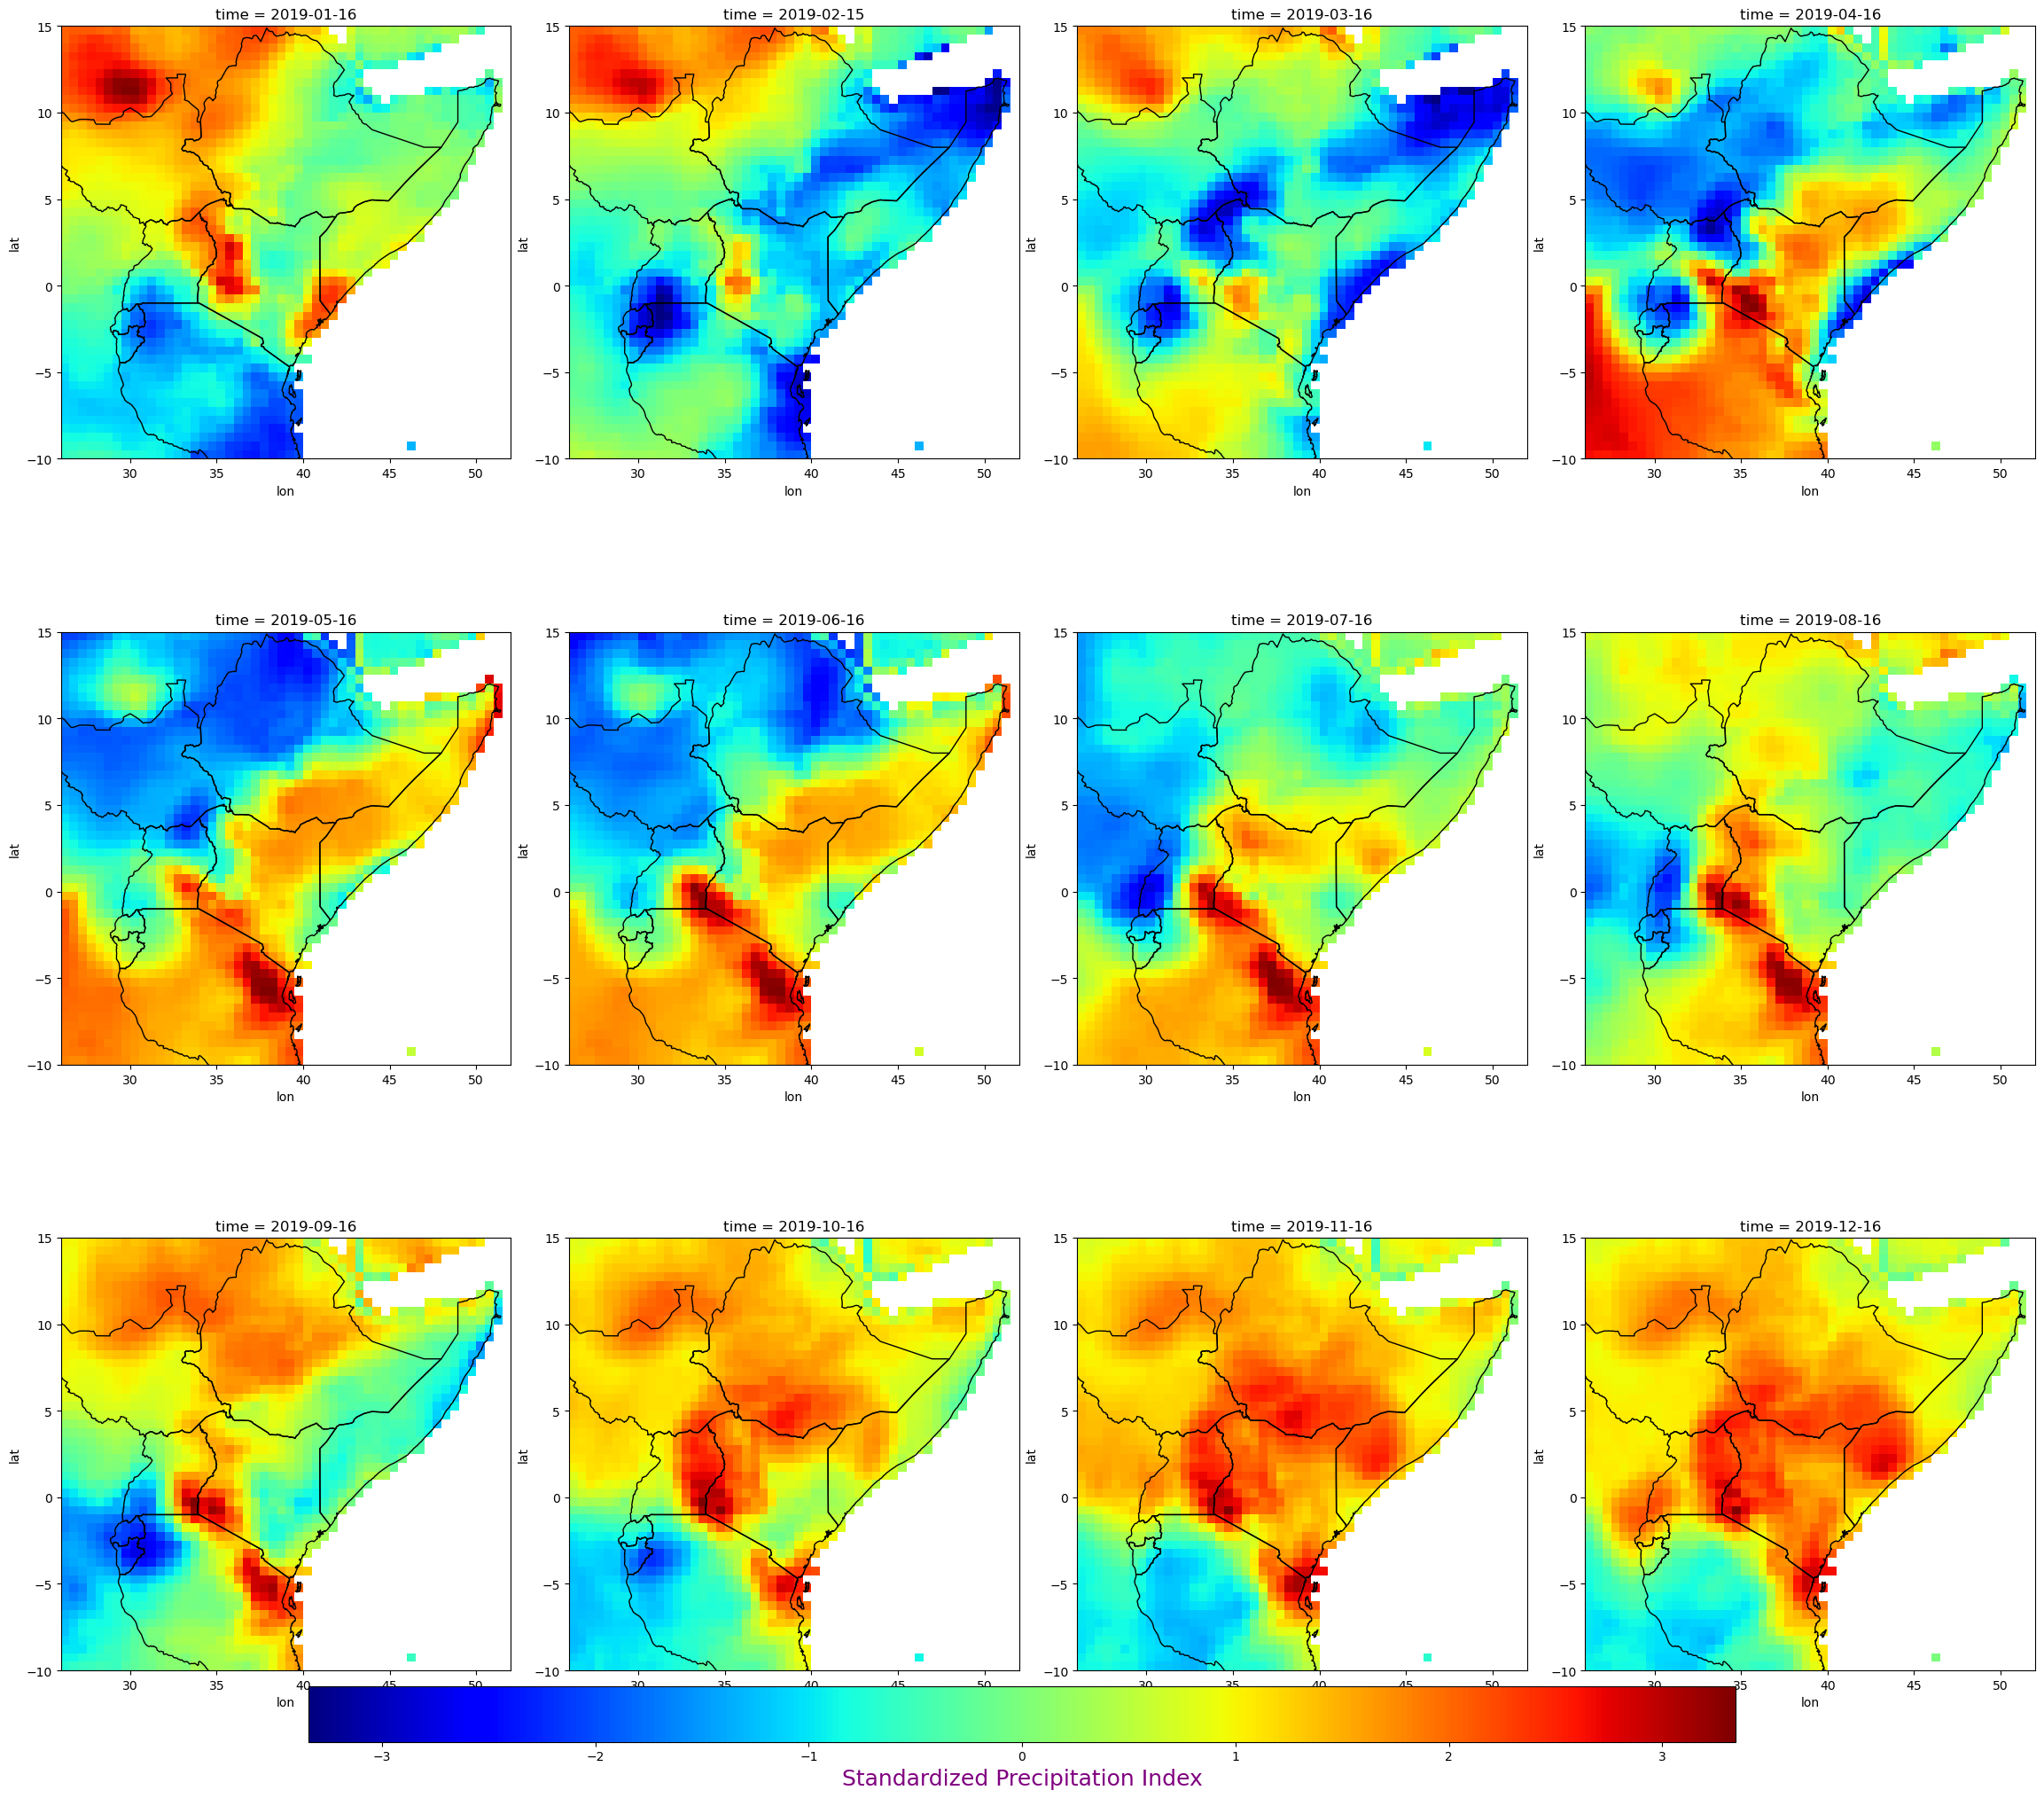

In [13]:
from distributed import Client
import warnings
import pandas as pd
import xarray as xr
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline

# Suppress warnings
warnings.filterwarnings("ignore")

da_data = xr.open_dataset('C:\\Users\\jeann\\Downloads\\AIMS_project\\cru_ts4.05.1981.2020.pre.data.nc')
ds_RR = da_data['pre']
ds_RR_EastAfrica = ds_RR.sel(lon=slice(23, 52), lat=slice(-12, 15), time=slice('1981', '2020'))
# Reading shapefile
east_africa = gpd.read_file("C:\\Users\\jeann\\Downloads\\AIMS_project\\Eastern_afican.shp")

# Standardized Precipitation Index Function
def spi(ds, thresh, dimension):
    # ds - data ; thresh - time interval / scale; dimension - dimension as a string

    # Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time=thresh, center=False).mean(dim='time', min_periods=1)

    # Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False)  # Change infinity to NaN

    ds_mu = ds_ma.mean(dimension)

    # Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)

    # Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)

    # Avoid division by zero
    ds_sum = ds_sum.where(ds_sum != 0, 1e-9)

    # Computing essentials for gamma distribution
    n = ds_In[thresh - 1:, :, :].count(dimension)  # size of data
    A = np.log(ds_mu) - (ds_sum / n)  # Computing A
    alpha = (1 / (4 * A)) * (1 + (1 + ((4 * A) / 3)) ** 0.5)  # Computing alpha  (a)
    beta = ds_mu / alpha  # Computing beta (scale)

    # Gamma Distribution (CDF)
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)

    # Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  # loc is mean and scale is standard dev.

    return ds_ma, ds_In, ds_mu, ds_sum, n, A, alpha, beta, gamma, norm_spi

i = 3
spi_6_2015 = da_data.sel(time='2019')# here you can adjust year as you want
da_data1 = spi(ds_RR_EastAfrica, i, 'time')[9]

# create a 4x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(23, 21))
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # adjust the spacing between subplots

# loop through each month of 1985 and plot the SPI on the corresponding subplot
for idx, ax in enumerate(axes.flat):
    time = '2019-' + str(idx + 1).zfill(2)  # create a string for the month with leading zero
    ax.set_title(time)
    da_data1 = spi(ds_RR_EastAfrica, 9, 'time')[9]
    im = da_data1.sel(time=time).plot(ax=ax, cmap='jet', add_colorbar=False)  #
    east_africa.plot(ax=ax, facecolor='none', edgecolor='black', vmin=-2.5, vmax=2.5)

# create a single colorbar and adjust its position
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.03])
# adjust the position of the colorbar
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')  # set orientation to horizontal
cbar_ax.set_xlabel('Standardized Precipitation Index', fontsize=18, color='purple')  # set x-label
plt.tight_layout(pad=0.5)  # Add padding
plt.show()


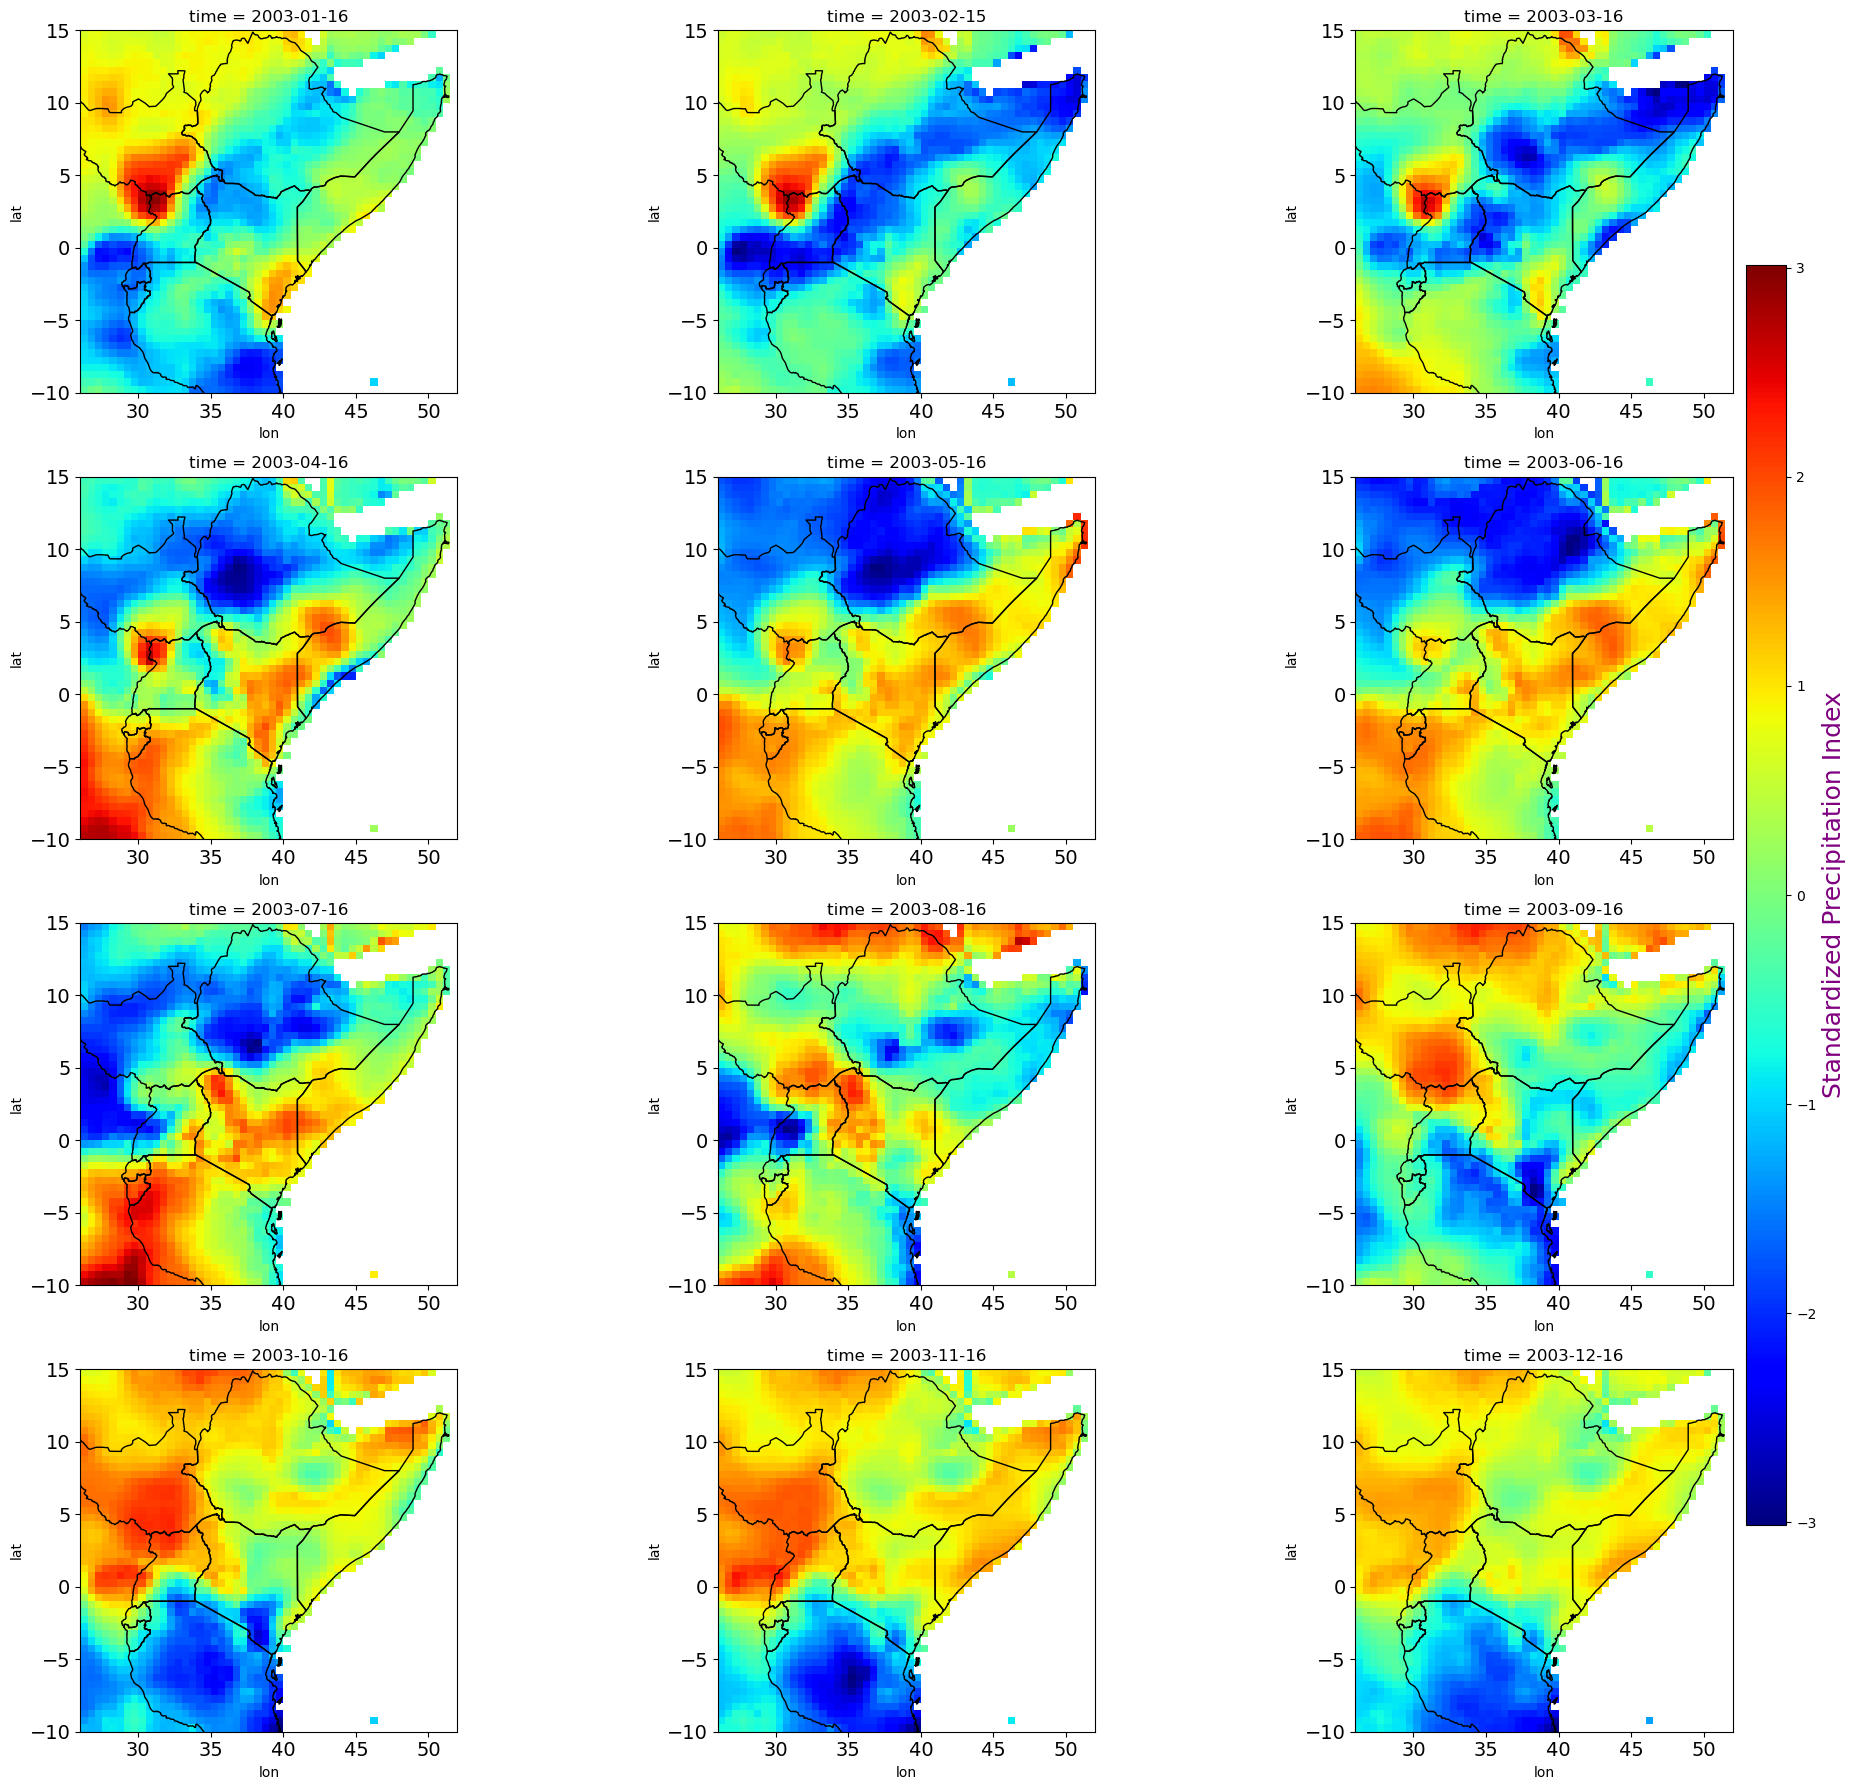

In [12]:
from distributed import Client
import warnings
import pandas as pd
import xarray as xr
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import geopandas as gpd


%matplotlib inline

da_data = xr.open_dataset('cru_ts4.05.1981.2020.pre.data.nc')
ds_RR = da_data['pre']
ds_RR_EastAfrica = ds_RR.sel(lon=slice(23,52), lat=slice(-12,15),time=slice('1981','2020'))
# Reading shapefile
east_africa = gpd.read_file("C:\\Users\\jeann\\Downloads\\AIMS_project\\Eastern_afican.shp")

#Standardized Precipitation Index Function
def spi(ds, thresh, dimension):
    #ds - data ; thresh - time interval / scale; dimension - dimension as a string

    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time = thresh, center=False).mean(dim=dimension)

    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN

    ds_mu = ds_ma.mean(dimension)

    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)

    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)

    #Computing essentials for gamma distribution
    n = ds_In[thresh-1:, :, :].count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)

    #Gamma Distribution (CDF)
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)

    #Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  #loc is mean and scale is standard dev.

    return ds_ma, ds_In , ds_mu, ds_sum,n, A, alpha, beta, gamma, norm_spi

# create a figure with 12 subplots, one for each month of 1985
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 18))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # create a separate colorbar axis

# loop through each month of 1985 and plot the SPI on the corresponding subplot
for idx, ax in enumerate(axes.flat):
    time = '2003-' + str(idx+1).zfill(2) # create a string for the month with leading zero
    ax.set_title(time)
    da_data1 = spi(ds_RR_EastAfrica, 9, 'time')[9]
    im = da_data1.sel(time=time).plot(ax=ax, cmap='jet', add_colorbar=False) #
    east_africa.plot(ax=ax, facecolor='none', edgecolor='black', vmin=-2.5, vmax=2.5)


# create a single colorbar and adjust its position
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Standardized Precipitation Index',fontsize=18,color='purple')
for ax in axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
#plt.savefig('SPI2003.png')
